<a href="https://colab.research.google.com/github/SahanaRaghu/ML/blob/master/Copy_of_data_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Input_dpci_pog_preprocessed.csv to Input_dpci_pog_preprocessed (1).csv


In [0]:
#Import to dataframe
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import io
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

input_data = pd.read_csv(io.StringIO(uploaded['Input_dpci_pog_preprocessed.csv'].decode('utf-8')))

input_data = input_data.reindex(
    np.random.permutation(input_data.index))

In [6]:
input_data.head(10)

,data,target
4,008090312,dpci
13,A137K1Q,pog
14,A107A7D,pog
19,A119NHM,pog
8,456010335,dpci
11,A119NVT,pog
1,266080005,dpci
0,007070049,dpci
9,347070048,dpci
3,058190207,dpci


In [0]:
def preprocess_features(input_data_dataframe):
  """Prepares input features from data set.

  Args:
    input_data_dataframe: A Pandas DataFrame expected to contain data
      from the data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """

  features = pd.DataFrame()
  features["lengthBy10"] = input_data_dataframe["data"].apply(lambda l: len(l)/10)
  
  length = input_data_dataframe['data'].apply(lambda l: len(l)).max()
  i = 1
  while(i<=length):
    features[str(i)] = input_data_dataframe['data'].apply(lambda l: 1 if (str.isdigit(l[i-1:i]) and l[i-1:i] != "") else 0 if (l[i-1:i] == "") else 2)
    i = i+1
  
  return features

def preprocess_targets(input_data_dataframe):
  """Prepares target features (i.e., labels) from data set.

  Args:
    input_data_dataframe: A Pandas DataFrame expected to contain data
      from the data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets['data_type'] = input_data_dataframe['target'].apply(lambda l: 1 if (l=='dpci') else 0)
  return output_targets

In [0]:
#---Divide data into training & validation data---

# Choose the first 14 out of 20 examples for training.
training_examples = preprocess_features(input_data.head(14))
training_targets = preprocess_targets(input_data.head(14))

# Choose the last 6 out of 20 examples for validation.
validation_examples = preprocess_features(input_data.tail(6))
validation_targets = preprocess_targets(input_data.tail(6))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.head())
print("Validation examples summary:")
display.display(validation_examples.head())

print("Training targets summary:")
display.display(training_targets.head())

Training examples summary:


,lengthBy10,1,2,3,4,5,6,7,8,9
3,0.9,1,1,1,1,1,1,1,1,1
6,0.9,1,1,1,1,1,1,1,1,1
19,0.7,2,1,1,1,2,2,2,0,0
5,0.9,1,1,1,1,1,1,1,1,1
4,0.9,1,1,1,1,1,1,1,1,1


Validation examples summary:


,lengthBy10,1,2,3,4,5,6,7,8,9
0,0.9,1,1,1,1,1,1,1,1,1
15,0.7,2,1,1,1,2,1,1,0,0
9,0.9,1,1,1,1,1,1,1,1,1
7,0.9,1,1,1,1,1,1,1,1,1
17,0.7,2,1,1,1,2,2,2,0,0


Training targets summary:


,data_type
3,1
6,1
19,0
5,1
4,1


In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
# Training model using linear classification model of Tensor flow

def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["data_type"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["data_type"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["data_type"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.11
  period 01 : 0.08
  period 02 : 0.04
  period 03 : 0.03
  period 04 : 0.03
  period 05 : 0.02
  period 06 : 0.02
  period 07 : 0.02
  period 08 : 0.01
  period 09 : 0.01
Model training finished.


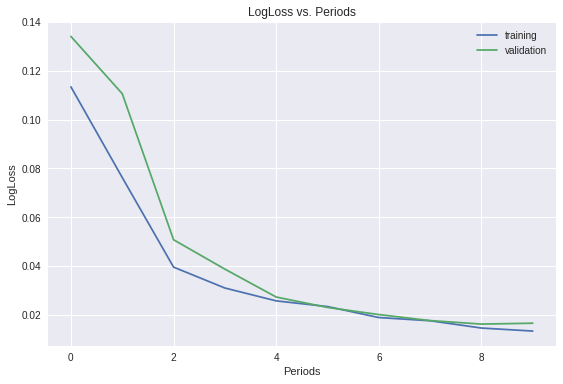

In [0]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.3,
    steps=50,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [0]:
# Calculate Accuracy

predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["data_type"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 1.00
Accuracy on the validation set: 1.00


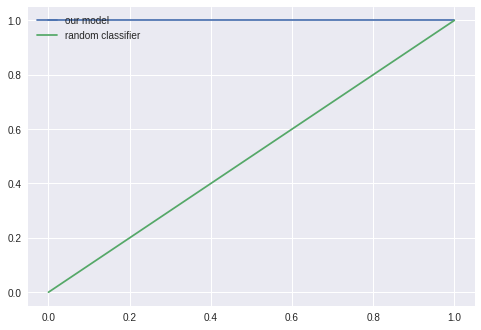

In [0]:
#Calculate true positive, false positoive rates to plot ROC curve
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)

# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

In [0]:
validation_targets.head(6)

,data_type
0,1
15,0
9,1
7,1
17,0
8,1


In [0]:
  # Predicted output in Validation set
  
  output = pd.DataFrame()
  output["result"] = validation_probabilities

In [0]:
output.head(6)

,result
0,1.0
1,0.0
2,1.0
3,1.0
4,0.0
5,1.0
